In [6]:
import gymnasium as gym
from tensorflow.keras import models, layers, optimizers
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import copy
import random
from collections import deque
import os
from time import strftime
import csv

In [7]:
class Logger:
    def __init__(self):
        # Create a unique log directory
        self.log_dir = f"log_{strftime('%Y_%m_%d-%H_%M_%S')}"
        os.makedirs(self.log_dir, exist_ok=True)

        # Paths for logging files
        self.rewards_log_path = os.path.join(self.log_dir, "rewards.csv")
        self.transitions_log_path = os.path.join(self.log_dir, "transitions.csv")
        self.evaluation_log_path = os.path.join(self.log_dir, "evaluation_rewards.csv")
        self.model_save_path = os.path.join(self.log_dir, "trained_model.keras")

        # Initialize the CSV log files
        with open(self.rewards_log_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["episode", "reward"])

        with open(self.transitions_log_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["episode", "state", "action", "next-state", "reward", "done", "truncated"])

        with open(self.evaluation_log_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["episode", "reward"])

    def log_reward(self, episode, reward):
        with open(self.rewards_log_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([episode, reward])
            
    def log_eval_reward(self, episode, reward):
        with open(self.rewards_log_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([episode, reward])

    def log_transition(self, episode, state, action, next_state, reward, done, truncated):
        with open(self.transitions_log_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([episode, state.tolist(), action, next_state.tolist(), reward, done, truncated])

    def save_model(self, model):
        model.save(self.model_save_path)

In [8]:
class ExponentialDecay:
    def __init__(self, initial_epsilon, decay_rate, min_epsilon):
        self.initial_epsilon = initial_epsilon
        self.current_epsilon = initial_epsilon
        self.decay_rate = decay_rate
        self.min_epsilon = min_epsilon

    def get_value(self):
        return max(self.current_epsilon, self.min_epsilon)

    def update(self):
        if self.current_epsilon > self.min_epsilon:
            self.current_epsilon *= self.decay_rate


class DQN:
    def __init__(
            self,
            main_model,
            target_model=None,
            epsilon=None,
            gamma=None,
            action_space=None,
            max_buffer=50000
    ) -> None:
        self.action_space = copy.deepcopy(action_space)
        self.epsilon = epsilon
        self.gamma = gamma
        self.buffer_replay = deque(maxlen=max_buffer)
        self.main_model = main_model
        self.target_model = target_model
        self.loss = tf.keras.losses.Huber()
        self.optimizer = optimizers.Adam(learning_rate=0.001)

    def select_action(self, state):
        if random.random() < self.epsilon.get_value():
            self.epsilon.update()
            return random.choice(self.action_space)
        else:
            return self.select_best_action(state)

    def select_best_action(self, state):
        q_values = self.main_model.predict(state[np.newaxis], verbose=0)
        return np.argmax(q_values)

    def store_transition(self, state, action, next_state, reward, done, truncated):
        self.buffer_replay.append((state, action, next_state, reward, done, truncated))

    def sample_minibatch(self, batch_size):
        indices = np.random.choice(len(self.buffer_replay), size=batch_size)
        return [self.buffer_replay[idx] for idx in indices]

    def train(self, batch_size=32):
        if len(self.buffer_replay) < batch_size:
            return
        
        minibatch = self.sample_minibatch(batch_size)
        states, actions, next_states, rewards, dones, truncates = map(np.array, zip(*minibatch))
        with tf.GradientTape() as tape:
            next_q_values = self.target_model(next_states)
            q_targets = np.max(next_q_values, axis=-1)
            q_targets = rewards + (1 - (dones | truncates)) * tf.squeeze(q_targets) * self.gamma
            current_q_values = self.main_model(states)
            indices = tf.stack([tf.range(len(actions)), actions], axis=1)
            q_values_selected = tf.gather_nd(current_q_values, indices)
            loss = self.loss(q_values_selected, q_targets)
            
        value_grads = tape.gradient(loss, self.main_model.trainable_variables)
        self.optimizer.apply_gradients(zip(value_grads, self.main_model.trainable_variables))

    def update_target_model(self, weights=None):
        if weights is not None:
            self.target_model.set_weights(weights)
        else:
            self.target_model.set_weights(self.main_model.get_weights())


class CreateNetwork(tf.keras.Model):
    def __init__(self, output_dim):
        super(CreateNetwork, self).__init__()
        self.dens1 = layers.Dense(64, activation=tf.keras.activations.leaky_relu)
        self.dens2 = layers.Dense(64, activation='relu')
        self.dens3 = layers.Dense(output_dim)
        
    def call(self, state):
        x = self.dens1(state)
        x = self.dens2(x)
        x = self.dens3(x)
        return x
    



def train_agent(env, agent, episodes, update_target_freq, logger=None):
    rewards = []

    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        terminated = False
        steps = 0

        while not terminated  and steps < 1000:
            steps +=1
            action = agent.select_action(state)
            next_state, reward, done, truncated, info = env.step(action)
            agent.store_transition(state, action, next_state, reward, done, truncated)
            agent.train(batch_size=32)
            terminated = done or truncated
            # Log transitions
            # if logger:
            #     logger.log_transition(episode,state, action, next_state, reward, done, truncated)
                
            state = next_state
            total_reward += reward
        # Log rewards
        if logger:
            logger.log_reward(episode, total_reward)
            
        # Save the model
        # if logger:
        #     logger.save_model(agent.main_model)
        
        # Update target network
        if episode % update_target_freq == 0:
            agent.update_target_model()

        rewards.append(total_reward)
        print(
            f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon.get_value():.2f}, Steps: {steps}")
    print(f'AVG reward: {np.mean(rewards)}')
    return rewards



def evaluate_agent(env, agent, episodes, logger=None):
    rewards = []
    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        terminated = False
        while not terminated:
            action = agent.select_best_action(state)
            next_state, reward, done, truncated, info = env.step(action)
            terminated = done or truncated
            # Log transitions
            # if logger:
            #     logger.log_transition(episode,state, action, next_state, reward, done, truncated)
                
            state = next_state
            total_reward += reward
        # Log rewards
        if logger:
            logger.log_eval_reward(episode, total_reward)
            
        rewards.append(total_reward)
        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward:.2f}, Steps: {steps}")
    env.close()

    return rewards


def plot_rewards(root_folder, rewards, title, save_fig=False):
    plt.plot(rewards, label='Total Reward per Episode')
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.title(title)
    if save_fig:
        plt.savefig(root_folder + "/" + title + '_' + strftime("%Y_%m_%d_%H_%M_%S") +'_' + '.png')
    plt.legend()
    plt.show()

In [9]:
env = gym.make('LunarLander-v3')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n


Episode 1/1000, Total Reward: -245.43, Epsilon: 0.64, Steps: 117
Episode 2/1000, Total Reward: -101.43, Epsilon: 0.46, Steps: 120
Episode 3/1000, Total Reward: -288.58, Epsilon: 0.36, Steps: 102
Episode 4/1000, Total Reward: -34.82, Epsilon: 0.28, Steps: 159
Episode 5/1000, Total Reward: -140.65, Epsilon: 0.23, Steps: 213
Episode 6/1000, Total Reward: -38.23, Epsilon: 0.16, Steps: 351
Episode 7/1000, Total Reward: -619.28, Epsilon: 0.10, Steps: 656
Episode 8/1000, Total Reward: -102.47, Epsilon: 0.08, Steps: 393
Episode 9/1000, Total Reward: -235.22, Epsilon: 0.07, Steps: 346
Episode 10/1000, Total Reward: -24.98, Epsilon: 0.06, Steps: 358
Episode 11/1000, Total Reward: -31.30, Epsilon: 0.06, Steps: 248
Episode 12/1000, Total Reward: -13.13, Epsilon: 0.05, Steps: 308
Episode 13/1000, Total Reward: -203.91, Epsilon: 0.05, Steps: 247
Episode 14/1000, Total Reward: 0.69, Epsilon: 0.05, Steps: 337
Episode 15/1000, Total Reward: -99.85, Epsilon: 0.04, Steps: 393
Episode 16/1000, Total Rewar

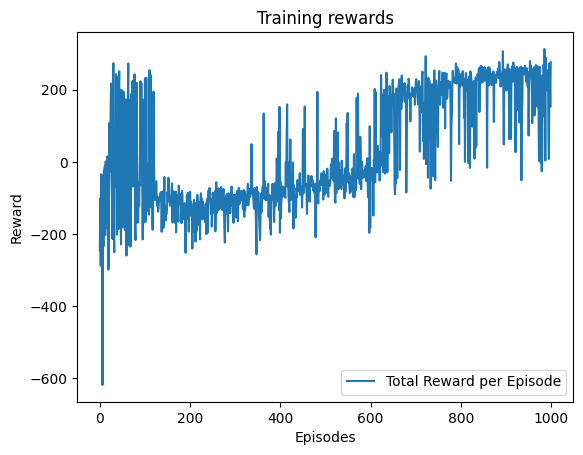

In [10]:
# Training cell
main_network = CreateNetwork(action_dim)
target_network = CreateNetwork(action_dim)
epsilon_schedule = ExponentialDecay(initial_epsilon=1.0, decay_rate=0.995, min_epsilon=0.01)

agent = DQN(
    main_model=main_network,
    target_model=target_network,
    epsilon=epsilon_schedule,
    gamma=0.99,
    action_space=list(range(action_dim))
)
logger = Logger()

training_episodes = 1000
training_rewards = train_agent(env=env, agent=agent, episodes=training_episodes,update_target_freq=20 ,logger=logger)
plot_rewards(logger.log_dir, training_rewards, "Training rewards", True)


In [11]:
# Uncomment code to load model and initialize the agent
#agent = DQN(main_model=tf.keras.models.load_model('model_name.keras'))
#logger = Logger()


In [12]:
# Evaluation cell
evaluation_episodes = 100
evaluate_rewards = evaluate_agent(env=env, agent=agent, episodes=evaluation_episodes, logger=logger)
plot_rewards(logger.log_dir,evaluate_rewards, "Evaluation rewards", True)

NameError: name 'steps' is not defined

In [ ]:
# Uncomment to see live action
# env2 = gym.make('LunarLander-v3', render_mode="human")
# evaluate_rewards = evaluate_agent(env=env2, agent=agent, episodes=1, logger=None)